---
title: 11.6 多GPU的简洁实现
date: 2024-8-10 14:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---

#### 

<!--more-->

# 6 多GPU的简洁实现

- 定义网络

In [11]:
import torch
from torch import nn
from d2l import torch as d2l

#@save
def resnet18(num_class, in_channels=1):
    '''稍加修改的resnet18'''
    def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(d2l.Residual(in_channels, out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(d2l.Residual(out_channels, out_channels))
        return nn.Sequential(*blk)
    
    net = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64), 
        nn.ReLU())
    net.add_module('resnet_block1', resnet_block(64, 64, 2, first_block=True))
    net.add_module('resnet_block2', resnet_block(64, 128, 2))
    net.add_module('resnet_block3', resnet_block(128, 256, 2))
    net.add_module('resnet_block4', resnet_block(256, 512, 2))
    net.add_module('global_avg_pool', nn.AdaptiveAvgPool2d((1, 1)))
    net.add_module('fc', nn.Sequential(nn.Flatten(), nn.Linear(512, num_class)))
    return net

## 6.2 网络初始化

In [13]:
net = resnet18(10)
# 获取GPU列表
devices = d2l.try_all_gpus()
print(devices)

[device(type='cuda', index=0)]


## 6.3 训练

test acc: 0.93, 40.4 sec/epoch on [device(type='cuda', index=0)]


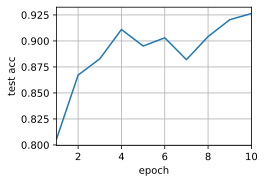

In [14]:
def train(net, num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    def init_weights(m):
        if type(m) in [nn.Linear, nn.Conv2d]:
            nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # 在多个GPU上设置模型
    net = nn.DataParallel(net, device_ids=devices)  #1
    trainer = torch.optim.SGD(net.parameters(), lr)
    loss = nn.CrossEntropyLoss()
    timer, num_epochs = d2l.Timer(), 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    for epoch in range(num_epochs):
        net.train()
        timer.start()
        for X, y in train_iter:
            trainer.zero_grad()
            X, y = X.to(devices[0]), y.to(devices[0])
            l = loss(net(X), y)
            l.backward()
            trainer.step()
        timer.stop()
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(net, test_iter),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')
    
# 单GPU训练
train(net, num_gpus=1, batch_size=256, lr=0.1)